In [1]:
## TMO 2017-2018: practica-toxic.py
# Dpto. de C. de la Computación e I.A. (Univ. de Sevilla)
#=====================================================================

# ********************************************************************
# Nombre: Jorge Miguel
# Apellidos: García García
# ********************************************************************

# **************************** IMPORTANTE ****************************
# - Recordar escribir el nombre en la cabecera de este fichero.
# ********************************************************************

# ********************************************************************
# HONESTIDAD ACADÉMICA Y COPIAS: la realización de los ejercicios es
# un trabajo personal, por lo que deben completarse por cada
# estudiante de manera individual.  La discusión y el intercambio de
# información de carácter general con los compañeros se permite (e
# incluso se recomienda), pero NO AL NIVEL DE CÓDIGO. Igualmente el
# remitir código de terceros, obtenido a través de la red o cualquier
# otro medio, se considerará plagio.

# Cualquier plagio o compartición de código que se detecte significará
# automáticamente la calificación de CERO EN LA ASIGNATURA para TODOS
# los alumnos involucrados. 
# ********************************************************************

# Se pide crear un modelo de clasificación con alguno de los algoritmos
# vistos en clase e implementados en la librería scikit-learn, también se
# permite el uso de xgboost y keras (tensorflow). Se valorará
# el ajuste de parámetros realizado (aplicando validación cruzada), así como
# la transformaciones sobre los datos desarrolladas para mejorar el calidad
# (score) del modelo por validación cruzada (un buen ejemplo es el notebook
# Left que se puede encontrar en la enseñanza virtual)

# El conjunto de datos corresponde a comentarios realizados en wikipedia.
# Se pretende determinar si los comentarios tiene un carga negativa o no.
# que un anuncio dado tendrá para la comunidad de usuarios de este portal.
# Cada comentario puede ser clasificado como tóxico, muy tóxico, obsceno,
# insultante, con carga de odio y/o amenazante.

#    1. De los texto se pueden obtener atributos como la longitud, número 
#       de palabras, número de palabras únicas, número de mayúsculas, etc... 
#       También se pueden aplicar técnicas de vectorización de textos como 
#       CountVectorizer o TF-IDF entre otras. 
#    2. Se puede usar diferentes algoritmos: regresión lineal, naive bayes, 
#       random forest y despues intentar ensamblarlos (obtener la media de las
#       predicciones)

# Estas son algunas de las tranformaciones que se pueden realizar, pero no las
# únicas. Cualquier otra transformación que se lleve a cabo sobre los datos
# será tenida en cuenta positivamente.

# Se deberá entregar este archivo con las implementaciones realizadas y
# comentadas, el archivo de predicciones del mejor modelo encontrado y el score 
# asociado por cross-validación y el proporcionado por kaggle (enviar a 
# dsolis@us.es)

# Toda la información necesaria y los conjuntos de datos se pueden encontrar en:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

# *******************************************************************
# IMPORTANTE: El plazo de entrega es hasta la finalización de la 
# competición (20 de Febrero).
# ********************************************************************

# *******************************************************************
# IMPORTANTE: La competición está activa. Debéis subir las predicciones
# y que la plataforma os dé el score sobre el test. Podeis usar el nombre
# de usuario que considereis oportuno.
# ********************************************************************

# ********************************************************************
# IMPORTANTE: Se pueden consultar y usar los ejemplos de código y 
# transformaciones encontradas en: 
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/kernels
# ********************************************************************

# ********************************************************************
# IMPORTANTE: Para resolver cualquier duda contactar con David Solís 
# (dsolis@us.es)
# ********************************************************************



## Carga de librerías principales

In [2]:
#!pip install spacy

In [3]:
import os
import pandas as pd
import numpy as np

#propias
import constants as ct
from utils import get_upper_case_prop, get_punctuation_prop, process_text
from utils_plot import PlotLosses
import string_dists as stds

#keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Layer, Lambda
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from functools import reduce
#from tqdm import tqdm

Using TensorFlow backend.


In [4]:
#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
import scipy.sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

### Settings

In [5]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
pd.options.display.width = 1000
pd.options.display.max_colwidth = 200

#settingsimread
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

Cargamos también el array de badwords que hemos preparado

In [6]:
#BLACK_LIST = pd.read_csv('arrBad', index_col=None, quotechar="'")
#BLACK_LIST = BLACK_LIST.index

## Definición de los datasets

### Conjunto de entrenamiento

In [7]:
train = pd.read_csv('train.csv', index_col='id')
X_train = train['comment_text'].to_frame()

In [8]:
n_final_cols = X_train.shape[0]

In [9]:
ct.OBJECTIVE_COLS

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [10]:
Y_train = train[ct.OBJECTIVE_COLS]

Vemos que el dataset tiene clases muy desequilibradas, especialmente **threat** y **identity_hate**

In [11]:
Y_train.sum().div(Y_train.shape[0] / 100).sort_values(ascending=False)

toxic            9.584448
obscene          5.294822
insult           4.936361
severe_toxic     0.999555
identity_hate    0.880486
threat           0.299553
dtype: float64

### Conjunto Test

In [12]:
X_test = pd.read_csv('test.csv', index_col='id')

In [13]:
X_test.shape

(153164, 1)

In [14]:
X_test.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja...
0000247867823ef7,"== From RfC == \r\n\r\n The title is fine as it is, IMO."
00013b17ad220c46,""" \r\n\r\n == Sources == \r\n\r\n * Zawe Ashton on Lapland — / """
00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your..."
00017695ad8997eb,I don't anonymously edit articles at all.


### Conjunto combinado

In [15]:
X_full = pd.concat([X_train, X_test])
X_full.shape

(312735, 1)

## Exploración de comentarios

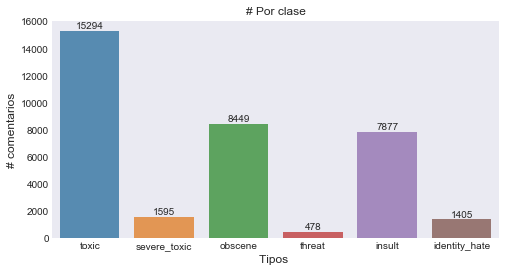

In [16]:
x=Y_train.iloc[:,:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# Por clase")
plt.ylabel('# comentarios', fontsize=12)
plt.xlabel('Tipos ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Podemos ver las implicaciones entre las diferentes etiquetas

In [17]:
implications = pd.DataFrame(np.nan, index=Y_train.columns, columns=Y_train.columns)

for col_ant in Y_train.columns:
    for col_con in Y_train.columns:
        
        selection_df = Y_train.loc[Y_train[col_ant] == 1]
        n_ant = selection_df.shape[0]
        n_con = selection_df[col_con].sum()
        implications.loc[col_ant, col_con] = n_con / n_ant
        
implications

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.104289,0.518242,0.029358,0.480188,0.085131
severe_toxic,1.000000,1.000000,0.951097,0.070219,0.859561,0.196238
obscene,0.938099,0.179548,1.000000,0.035626,0.728489,0.122145
threat,0.939331,0.234310,0.629707,1.000000,0.642259,0.205021
insult,0.932335,0.174051,0.781389,0.038974,1.000000,0.147264
identity_hate,0.926690,0.222776,0.734520,0.069751,0.825623,1.000000


## Ingeniería de atributos

 - Número de frases
 - Número de palabras
 - Número de palabras (únicas)
 - Número de letras
 - Número de signos de puntuacion
 - Número de mayúsculas
 - Número de _title case_
 - Número de stopwords (inglés)
 - Número de interrogantes
 - Número de signos de admiración
 - Número y control de IPs
 - Número y control de usuarios
 - Número y control de enlaces
 - Artículos
 
 - Media de lontigud de palabra
 - Ratio (100) de palabras únicas frente a palabras
 - Ratio (100) de signos de puntuacion frente a palabras
 - Ratio (100) de mayúsculas frente a letras (omitimos signos de puntuacion)
 
 - _Ratio de distancia a palabras de una bolsa de palabras malsonantes/ofensivas_ (deprecated) habría que pensar otra manera de hacer este cálculo ya que explota debido a la alta combinatoriedad, "orden 10^10"

In [18]:
# Counting
X_full['n_sentences'] = X_full["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
X_full['n_words']=X_full["comment_text"].apply(lambda x: len(str(x).split()))
X_full['n_unique_word']=X_full["comment_text"].apply(lambda x: len(set(str(x).split())))
X_full['n_letters']=X_full["comment_text"].apply(lambda x: len(str(x)))
X_full["n_punct"] =X_full["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
X_full["n_upper"] = X_full["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
X_full["n_title"] = X_full["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
X_full["n_stopwords"] = X_full["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
X_full['n_qmark'] = X_full['comment_text'].apply(lambda x: len(re.findall("\?",str(x))))
X_full['n_exmark'] = X_full['comment_text'].apply(lambda x: len(re.findall("!",str(x))))
X_full['ip']=X_full["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
X_full['n_ip']=X_full["ip"].apply(lambda x: len(x))
X_full['link']=X_full["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
X_full['n_links']=X_full["link"].apply(lambda x: len(x))
X_full['article_id']=X_full["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
X_full['article_id_flag']=X_full.article_id.apply(lambda x: len(x))
X_full['username']=X_full["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
X_full['n_usernames']=X_full["username"].apply(lambda x: len(x))

In [19]:
# Measures
X_full["mean_word_len"] = X_full["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

X_full['per_wordunique']=X_full['n_unique_word']*100/X_full['n_words']
X_full['per_punct']=X_full['n_punct']*100/X_full['n_words']
X_full['per_upper']=X_full['n_upper']*100/(X_full['n_letters']-X_full['n_punct'])

Procesamos el texto para calcular la ratio de palabras cercanas a la BLACK_LIST

In [20]:
X_full['comment_text'] = X_full["comment_text"].apply(lambda x:process_text(x)  )

##### Limpiamos el BLACK_LIST
Definimos una nueva columna que nos medirá la ratio de palabras cercanas al BLACK_LIST. En principio era idea establecer una medida de ratio de palabras del blacklist en cada comentario, pero por performance no he sido capaz de lograr ponerlo

In [21]:
#Aquí es donde se queda pillado
#X_full['d_badwords']= stds.dist_series_to_series(X_full["comment_text"],BLACK_LIST).sum()/ X_full['n_words']
#BLACK_LIST
#bl = set(BLACK_LIST)
#len(bl)

### TF-idf Vectorizer

In [34]:
count_vectorizer = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

count_vectorizer.fit(X_full['comment_text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=30000, min_df=150,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=1,
        stop_words='english', strip_accents='unicode', sublinear_tf=1,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=1,
        vocabulary=None)

In [35]:
train_vec =  count_vectorizer.transform(X_full['comment_text'].iloc[:X_train.shape[0]]).toarray()
test_vec = count_vectorizer.transform(X_full['comment_text'].iloc[X_train.shape[0]:]).toarray()

In [36]:
train_vec.shape[1]

7045

Una vez que tenemos todas las características que queremos, volvemos a separar el dataset en el de entrenamiento y el de test

In [37]:
custom_train = X_full.iloc[0:len(X_train),]
custom_test  = X_full.iloc[len(X_train):,]

Ponemos un CAP de 200 palabras.

In [38]:
#custom_train['n_unique_word'].loc[custom_train['n_unique_word']>200] = 200

## Definición del modelo

In [39]:
SELECTED_COLS=['n_sentences','n_words','n_unique_word','n_letters'
               ,'n_punct','n_upper','n_title','n_stopwords'
               ,'mean_word_len','per_wordunique','per_punct']#,'d_badwords']

target_x = custom_train[SELECTED_COLS]
test_x   = custom_test[SELECTED_COLS]

In [41]:
train_sparse = scipy.sparse.hstack([target_x,train_vec])
test_sparse  = scipy.sparse.hstack([test_x,test_vec])

In [42]:
train = train_sparse.todense()

In [46]:
inp = Input(shape=(train_vec.shape[1]+len(SELECTED_COLS),))
x = Dense(128, init='normal', activation="relu")(inp)
x = Dropout(0.1)(x)
x = Dense(128, init='normal', activation='relu')(x)
x = Dropout(0.1)(x)
#x = Dense(64, init='normal', activation='relu')(x)
x = Dense(32, init='normal', activation='relu')(x)
x = Dense(6, init='normal', activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Algunos parámetros para el modelo

In [47]:
batch_size = 128
epochs = 20
val_prop = 0.2
es_patience = 5
rlr_patience = 2
rlr_cooldown = 4
valid_split = 0.2
file_path = ''

In [48]:
early_stop = EarlyStopping(monitor='val_roc_auc', patience=es_patience, mode='max',  verbose=0)
checkpoint = ModelCheckpoint(file_path, monitor='val_roc_auc', verbose=0, mode='max',   save_best_only=True)
reduce_lr = ReduceLROnPlateau( monitor='val_roc_auc', 
                              factor=0.5, 
                              patience=rlr_patience, 
                              cooldown=rlr_cooldown, 
                              min_lr=1e-4)

callbacks_list = [checkpoint, early_stop, reduce_lr]

In [49]:
model.fit(train, Y_train, validation_split=valid_split, nb_epoch=epochs, batch_size=batch_size, callbacks=callbacks_list)

Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 67s 525us/step - loss: 0.1223 - acc: 0.9646 - val_loss: 0.0787 - val_acc: 0.9751
Epoch 2/20
127656/127656 [==============================] - 42s 333us/step - loss: 0.0714 - acc: 0.9764 - val_loss: 0.0633 - val_acc: 0.9785
Epoch 3/20
127656/127656 [==============================] - 43s 333us/step - loss: 0.0621 - acc: 0.9789 - val_loss: 0.0573 - val_acc: 0.9799
Epoch 4/20
127656/127656 [==============================] - 42s 332us/step - loss: 0.0588 - acc: 0.9795 - val_loss: 0.0679 - val_acc: 0.9779
Epoch 5/20
127656/127656 [==============================] - 43s 335us/step - loss: 0.0578 - acc: 0.9799 - val_loss: 0.0564 - val_acc: 0.9798
Epoch 6/20
127656/127656 [==============================] - 47s 369us/step - loss: 0.0548 - acc: 0.9805 - val_loss: 0.0588 - val_acc: 0.9788
Epoch 7/20
127656/127656 [==============================] - 45s 350us/step - loss: 0.0540 - acc: 0.9807

### Algunos Resultados

##### validation_split=0.2, nb_epoch=2 --> 
    - 76s 593us/step - loss: 0.0717 - acc: 0.9766 - val_loss: 0.0633 - val_acc: 0.9776
    - 75s 586us/step - loss: 0.0649 - acc: 0.9782 - val_loss: 0.0720 - val_acc: 0.9765

In [50]:
test = test_sparse.todense()

In [ ]:
pred = model.predict(test)

In [ ]:
from sklearn.metrics import log_loss
sample_submission = pd.read_csv("sample_submission.csv")

In [ ]:
sample_submission[ct.OBJECTIVE_COLS] = pred

In [ ]:
sample_submission.to_csv("result.csv", index=False)